In [41]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import TDAvectorizer

In [48]:

reload(TDAvectorizer)

<module 'TDAvectorizer' from '/Users/alekseiluchinsky/Work/STUDY/Thesis/VPB_Python/python/TDAvectorizer.py'>

In [49]:
vect = TDAvectorizer.TDAvectorizer()
vect.setParams({"output":"PL"})
assert vect.getParams("output") == "PL"

In [50]:
diags = []
for i in range(4):
    diags = diags + [vect.createEllipse()]

In [56]:
vect.fit(diags)
len(vect.diags)

4

In [53]:
vect

In [54]:
len(vect.diags)

2

In [47]:
vect.diags[0][0][-1]

array([0., 2.])

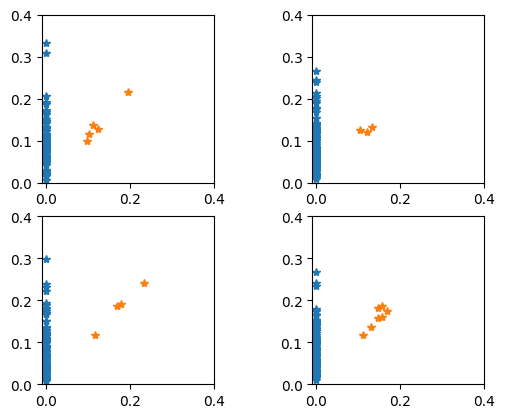

In [38]:
for i in range(len(vect.diags)):
    plt.subplot(2, 2, i+1)
    plt.plot( vect.diags[i][0][:,0], vect.diags[i][0][:,1], "*")
    plt.plot( vect.diags[i][1][:,0], vect.diags[i][1][:,1], "*")
    plt.xlim(-0.01, 0.4)
    plt.ylim(0, 0.4)
    plt.gca().set_aspect('equal', adjustable='box')